# Constant Proportion Portfolio Insurance

While seeking higher returns is always important, another crucial aspect of an effective investment strategy is loss prevention. `Constant Proportion Portfolio Insurance (CPPI)` is a simple intuitive investment strategy that aims to achieve the second objective -*i.e.,* to protect investor's capital. Under CPPI, we target a minimum level of wealth that we can tolerate -*i.e.*, **protection floor**. For instance, we can set the floor to be at 80 percent of the initial capital. The CPPI strategy ensures that we do not violate this floor.

The intuition behind this algorithm is to increase the risky investment in the portfolio during bull markets, and decrease it -by investing more in the risk-free asset- during bear markts. This is done so that if the decline in the risky asset price continues, we gradually reduce our investmnet in risky asset to a point we are no longer subject to risk so that the protection floor is not violated.


In this notebook, I start by a brief introduction of the CPPI algorithm. Then, I implement this algorithm in Python, and finally test its performance in a Monte-Carlo simulation exercise.

## Table of Contents

[1. An Introduction to CPPI](#1) 

[2. CPPI in Practice](#2) 
- [Extensions: Drawdown-Based CPPI](#2.1) 
- [Extensions: CPPI with A Cap](#2.2)

[3. A Monte-Carlo Simulation](#3) 
- [Stock Price Simulation: Brownian Motion](#3.1)
- [CPPI Simulation](#3.2)



In [199]:
import ipywidgets
import numpy as np
import pandas as pd
import seaborn as sns
import risk_mod as rm
import matplotlib.pyplot as plt 
from IPython.display import display

## An Introduction to CPPI  <a id="1"></a>

CPPI is a trading strategy that sets a floor on a portfolio value such that if the risky asset falls to its lowest expected value, the portfolio value will be at the floor. This limits the downside risk while maintaining a potential upside through exposure to the risky asset. To achieve this objective, each period a *constant proportion* of wealth is invested in the risky asset. The following figure depicts the CPPI algorithm 

<img src="cppi.png" alt="alt" width="500" height="500"/>


where current waelth is denoted by *CPPI* and the constant proportion for risky investment is *M*.

To better understand this strategy, note that given a protection floor, *F*, our goal is to be fully invested in the risk-free asset if we ever hit the floor. So, at any point in time we can, at most, lose $C = CPPI - F$. This is called our **cushion**. The amount invested in the the rsiky asset, then, would be a constant fraction of this cushion: 

$$\text{Risky Asset (E)} = M \times C$$



For instance if `M=3` and our protection floor is `80 percent` of total welath, then we should invest $3\times(100-80) = 60$ percent of our wealth in risky asset. 


### CPPI with A Cap  
A natural extension of this strategy would impose a cap to our gais in addition to a floor for our loss. In that case, if our current wealth is closer to the cap, we should more focus on not reaching the cap while if we are close to the floor, our concern should be not falling below it. Let's use $C$ to denote this investment cap. Define $T = \frac{C+F}{2}$:
$$
\begin{cases}
E = M \times (𝐶𝑃𝑃𝐼 − 𝐹) \hspace{10mm} \text{if } \hspace{4mm} CPPI < T\\[3mm]
E = M \times (C - 𝐶𝑃𝑃𝐼) \hspace{10mm} \text{if } \hspace{4mm} CPPI >= T\\
\end{cases}
$$


**Notes:**
1) dynamical adjustments:
The CPPI strategy is very powerful if the the portfolio is frequently adjusted. This way, during bear markets, as the cushion gets smaller, our positioning in the risky asset also becomes smaller. However, this constant updating may be costly. 

2) How is M determined?  
In reality, we only trade infrequently -say at the begining of each month. As a result of this time constraint, we face a risk where we may violate the floor before we get a chance to re-adjust our positions at the begining of the next month. This will happen if 
    * we invest a large portion of our portfolio in risky asset -large $M$-, AND 
    * the risky asset falls sharply before our next re-balancing decision.
    
 A rule of thumb is to take the inverse of the maximum expected fall as the $M$. In other words if we expect the maximum loss of our risky investment during our inaction period to be $l$, then $M = \frac{1}{l}$. For instance, if we believe the maximum losss is `25` percent, then $M=4$ ensures that we don't violate our floor until our next decision. 


3) Caveats of CPPI

    * In an oscillating market, this strategy loses money as we buy more risky assets in high prices and we'll sell them for cheap later on.
    * In a real market crash, this strategy leads to no investment in risky asset. This means no upside for our long-run investment. 
    * Investing more and more in risk-free asset could mean a lower liquidity level as the maturity of the entire portfolio rises. 



## CPPI in Practice  <a id="2"></a>

In this notebook, I work with historical monthly returns of the US Stock market obtained from [this](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) webpage. I work with the 30 industry classification. This dataset starts from `1926-07` and runs through `2023-06`. 

This dataset includes three files: 
* Industry Retrurns
* Market Size
* Number of Firms

After reading the `.csv` files, I do a bit of cleaning, which includes: 

1) dividing all returns by 100 as they are stored in percentages
2) force the index column to be a `datetime` object and set its period
3) clean-up the coulmn names as there are extra spaces

In [69]:
# Industry Retrun
ind_return         = pd.read_csv("30_Industry_Return.csv", header = 0, index_col=0)/100
ind_return.index   = pd.to_datetime(ind_return.index, format="%Y%m").to_period('M')
ind_return.columns = ind_return.columns.str.strip()

# Industry Size: Market Size
ind_msize         = pd.read_csv("30_Industry_Size.csv", header = 0, index_col=0)/100
ind_msize.index   = pd.to_datetime(ind_msize.index, format="%Y%m").to_period('M')
ind_msize.columns = ind_msize.columns.str.strip()

# Industry Size: Number of Firms

ind_nfirms         = pd.read_csv("30_Industry_NFirms.csv", header = 0, index_col=0)/100
ind_nfirms.index   = pd.to_datetime(ind_nfirms.index, format="%Y%m").to_period('M')
ind_nfirms.columns = ind_nfirms.columns.str.strip()

I set the time period to be `1980` onward. Also, to plot the data and get a better sense of our data.it, I consider a subset of industries:

In [70]:
# Time period
ind_return = ind_return["1980":].copy()
ind_msize  = ind_msize["1980":].copy()
ind_nfirms = ind_nfirms["1980":].copy()

# selected subset of industries
selection = ['Chems', 'Fin', 'Food', 'Games', 'Hlth', 'Oil', 'Rtail', 'Smoke', 'Steel', 'Telcm']

Text(0.5, 1.0, 'Cumulative Returs of Select Industries')

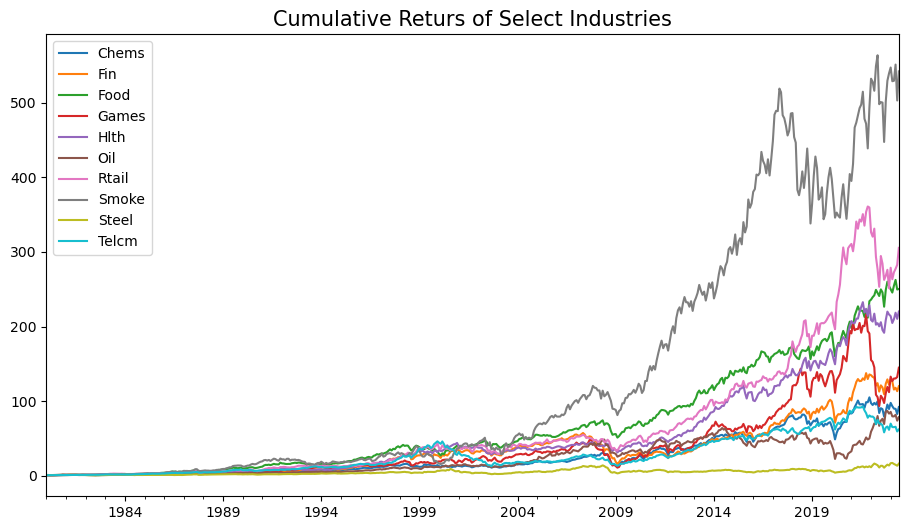

In [5]:
(ind_return[selection]+1).cumprod().plot(figsize = (11, 6))
plt.title ("Cumulative Returs of Select Industries", fontsize = 15)


Text(0, 0.5, 'x10 Million USD')

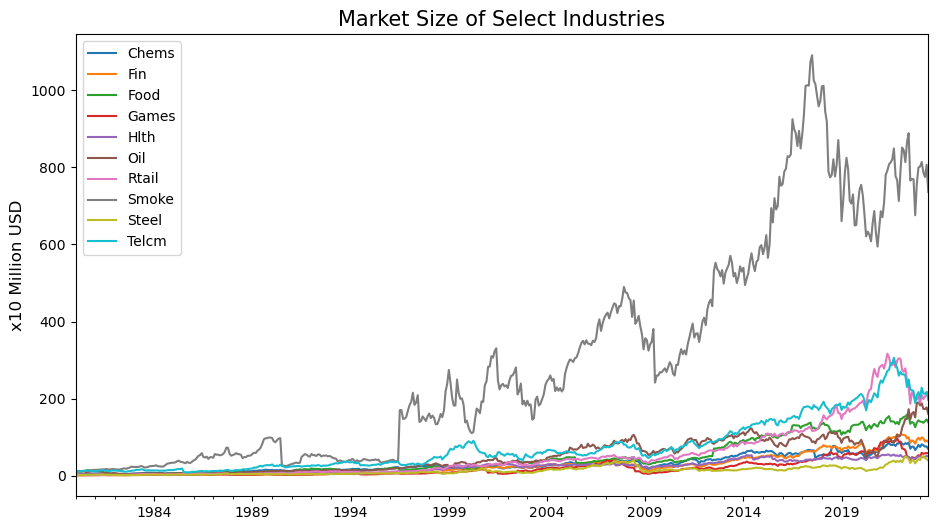

In [6]:
ind_msize[selection].plot(figsize = (11, 6))
plt.title ("Market Size of Select Industries", fontsize = 15)
plt.ylabel("x10 Million USD", fontsize = 12)

In [90]:
rm.summary_stats(ind_return.loc["2000":,:])

,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Food,9.114,12.885,-0.245,4.192,5.475,8.065,0.091,-31.096
Beer,9.097,14.322,-0.343,3.833,6.299,8.929,0.091,-27.137
Smoke,15.535,22.394,0.023,5.934,8.772,13.231,0.155,-43.369
Games,9.009,26.552,-0.303,5.296,11.857,17.850,0.090,-76.944
Books,1.692,22.485,0.252,6.566,9.371,13.743,0.017,-77.324
Hshld,6.784,14.167,-0.555,4.160,6.607,9.455,0.068,-38.137
Clths,11.167,22.901,-0.079,4.182,9.741,13.825,0.112,-56.605
Hlth,8.548,14.200,-0.283,3.205,6.267,8.602,0.085,-35.347
Chems,8.210,21.452,-0.243,4.208,9.584,13.550,0.082,-58.397
Txtls,5.069,32.011,0.430,10.141,11.845,21.035,0.051,-77.905


### CPPI Algorthim 
Implementing the CPPI algorithm requires asset allocation across `risky` and `rsikless` assets. In this simulation I consider the following assets:
* Risky Assets: the selected subset of industry indices
* Riskless Asset: an asset with a 3 percent return annually 

In reality, we should allocate our assets between an *optimal* portfolio of risky assets and the riskless asset. However, instead of doing that, I am going to look at the choice between each risky asset and the riskless asset separately. This may not be an optimal design for the portfolio but, for this excercise, it allows us to test a larger number of scenarios.


In [101]:
# risky assets
assets  = ['Books', 'Coal', 'Fin', 'Steel', 'Smoke']
risky_r = ind_return.loc["2000":,assets]

# risk-free asset: 3% per year, monthly 
riskless_r          = pd.DataFrame().reindex_like(risky_r)
riskless_r.loc[:,:] = 0.03/12


The parameters of the CPPI are as follows:
* initial assets are `1` USD
* target floor is `90` percent of the starting assets
* the multiplier is assumed to be equal to 3

Implementing this strategy requires three steps at each month:

1. Computing the cushion (asset value minus floor)
2. Computing the allocation to risky and riskless assets (based on the multiplier)
3. Computing the new value of the portfolio

In [167]:
# Parameters
start = 1                        # initital assets
floor = 0.90                     # floor is 90 percent of the starting assets
m     = 3                        # multiplier
  

## DataFrame to record values
cushion = pd.DataFrame().reindex_like(risky_r)
wealth  = pd.DataFrame().reindex_like(risky_r) 
risky_w = pd.DataFrame().reindex_like(risky_r)


# CPPI Algorithm with a static floor

floor_val  = start*floor
wealth_now = start


for period in range(len(risky_r.index)):
    
    cush_val = (wealth_now - floor_val)                  # value of cushion  
    share_r  = m * cush_val/wealth_now                   # share of risky investment
    share_r  = np.minimum(share_r, 1)
    share_r  = np.maximum(share_r, 0)
    
    wealth_new = (share_r * wealth_now) * (1 + risky_r.iloc[period]) + ((1.0-share_r) * wealth_now) * (1 + riskless_r.iloc[period])
   
   
    # save variables 
    cushion.iloc[period] = cush_val
    risky_w.iloc[period] = share_r
    wealth.iloc[period]  = wealth_new 

    wealth_now = wealth_new
    
# cumulative performance of risky assets
risky_prf = start*(1+risky_r).cumprod()


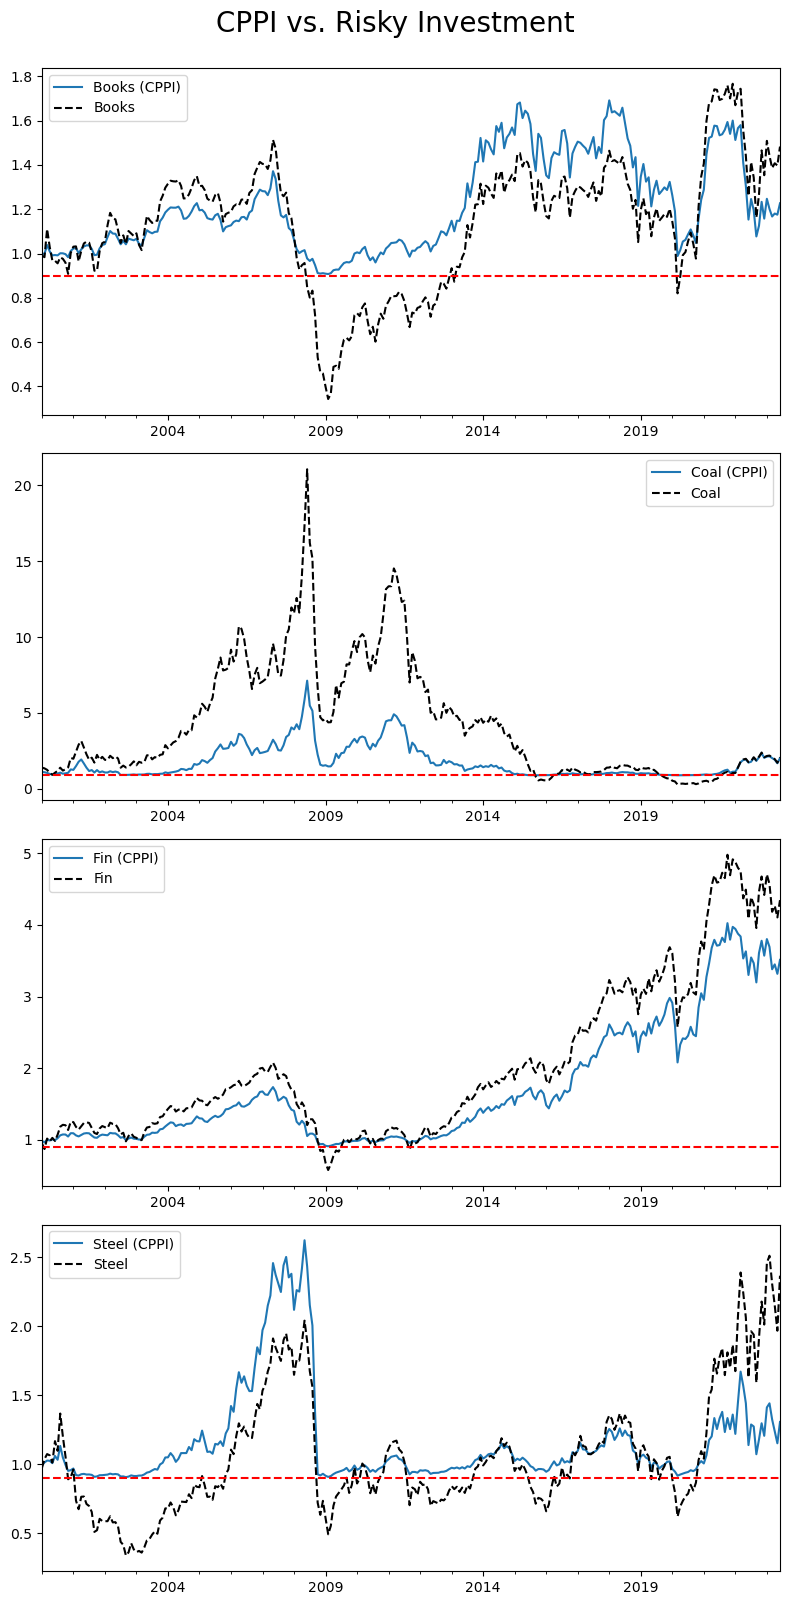

In [168]:
nrow = int(len(risky_r.columns)) 

fig, axs = plt.subplots(nrows = nrow, ncols = ncol, figsize = (8, nrow*4), sharey = False, sharex = False)
plt.subplots_adjust( wspace = 0.6)
fig.suptitle("CPPI vs. Risky Investment", fontsize = 20, y = 1)


axs = axs.ravel()

for index, ax, i in zip(risky_r.columns, axs, range(ncol*nrow)):
    wealth[index].plot(ax = ax, label = index + ' (' + 'CPPI' + ')', legend = True)
    risky_prf[index].plot(ax = ax, label = index, legend = True, color = 'black', linestyle = '--')
    ax.axhline(y=floor_val, color='r', linestyle='--')

fig.tight_layout()
plt.legend()
plt.show()

Text(0.5, 1.0, 'Weight of Risky Investment in the CPPI Portfolio')

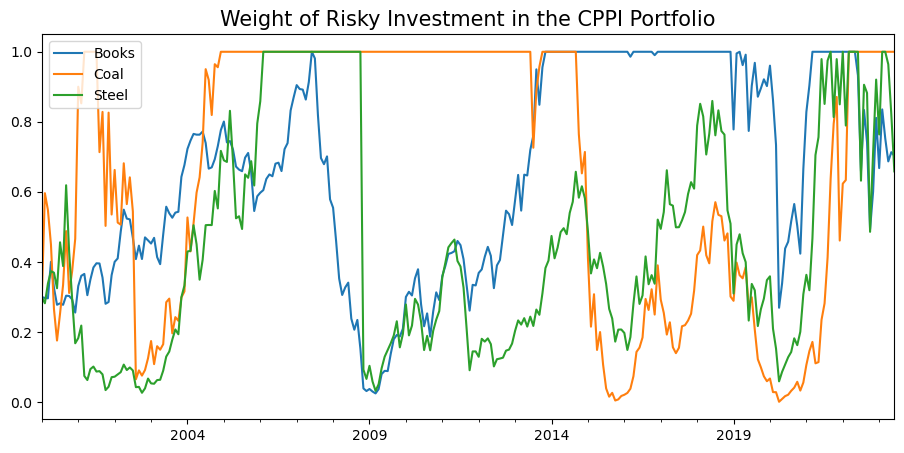

In [141]:
risky_w[['Books', 'Coal', 'Steel']].plot(figsize = (11, 5), legend = True)
plt.title("Weight of Risky Investment in the CPPI Portfolio", fontsize = 15)

In [142]:
print("                                     Performance of Risky Assets")
print("========================================================================================================")
rm.summary_stats(risky_r.iloc[:,:-1])


                                     Performance of Risky Assets


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Books,1.692,22.485,0.252,6.566,9.371,13.743,0.017,-77.324
Coal,3.147,47.416,0.006,3.525,21.097,28.434,0.031,-98.608
Fin,6.450,20.042,-0.487,4.691,9.384,13.275,0.064,-72.032
Steel,3.735,33.574,-0.155,3.545,15.446,20.826,0.037,-75.802


In [143]:
print("                                     Performance of CPII Strategy")
print("========================================================================================================")
rm.summary_stats(wealth.iloc[:,:-1].pct_change().dropna())

                                     Performance of CPII Strategy


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Books,0.882,13.741,-0.333,5.607,6.519,9.424,0.009,-41.558
Coal,2.562,33.736,-0.086,4.944,15.150,21.613,0.026,-87.369
Fin,5.562,14.252,-0.495,6.517,6.486,9.789,0.056,-47.464
Steel,1.181,18.984,-1.229,12.102,9.492,13.204,0.012,-65.332


**Conclusion:**
1) Drawdowns have significantly dropped, which shows the insurance power of the strategy.
2) Sharpe Ratios have expectedly dropped.
3) We have lost top returns and gained lower volatility.
4) Skewness is generally speaking more negative, which again shows that we have lost top returns.

### Extensions: Drawdown-Based CPPI <a id="2.1"></a>

The basic algorithm of CPPI protects a fixed floor -*e.g.,* in our previous example, this floor was 90 percent of our initial investment. However, this does not seem to be efficient; specially as over time, the value of our portfolio could grow so high than the floor. An alternative algorithm is the drawdown-based CPPI where we impose an explicit upper limit to our drawdown. In other words, our objective would be to ensure that the loss on the CPPI portfolio does not exceed the protected level. This is going to lead to a dynamic definition of the floor where instead of protecting a fixed wealth level, we shoulld protect an upper limit to our drawdon every period. For example, in the next example, I want to limit the drawdown to `15` percent. 



In [193]:
# risky assets
assets  = ['Books', 'Coal', 'Fin', 'Steel']
risky_r = ind_return.loc["2000":,assets]

# risk-free asset: 3% per year, monthly 
riskless_r          = pd.DataFrame().reindex_like(risky_r)
riskless_r.loc[:,:] = 0.03/12


# Parameters
start = 1                        # initital assets
floor = 0.90                     # floor is 90 percent of the starting assets
m     = 3                        # multiplier
dd    = 0.15                     # drawdon limit   


## DataFrame to record values
cushion = pd.DataFrame().reindex_like(risky_r)
wealth  = pd.DataFrame().reindex_like(risky_r) 
risky_w = pd.DataFrame().reindex_like(risky_r)
target  = pd.DataFrame().reindex_like(risky_r)

In [194]:
# CPPI Algorithm with a dynamic floor
floor_val  = start*floor
peak_val   = start*floor
wealth_now = start


for period in range(len(risky_r.index)):
      
    peak_val  = np.maximum(peak_val, wealth_now)         # dynamically deteremined peak
    floor_val = (1.0 - dd) * peak_val                    # dynamically deteremined floor
    
    cush_val = (wealth_now - floor_val)                  # value of cushion  
    share_r  = m * cush_val/wealth_now                   # share of risky investment
    share_r  = np.minimum(share_r, 1)
    share_r  = np.maximum(share_r, 0)
    
    wealth_new = (share_r * wealth_now) * (1 + risky_r.iloc[period]) + ((1.0-share_r) * wealth_now) * (1 + riskless_r.iloc[period])
   
   
    # save variables 
    cushion.iloc[period] = cush_val
    risky_w.iloc[period] = share_r
    wealth.iloc[period]  = wealth_new 
    target.iloc[period]  = floor_val
    
    wealth_now = wealth_new
    
# cumulative performance of risky assets
risky_prf = start*(1+risky_r).cumprod()


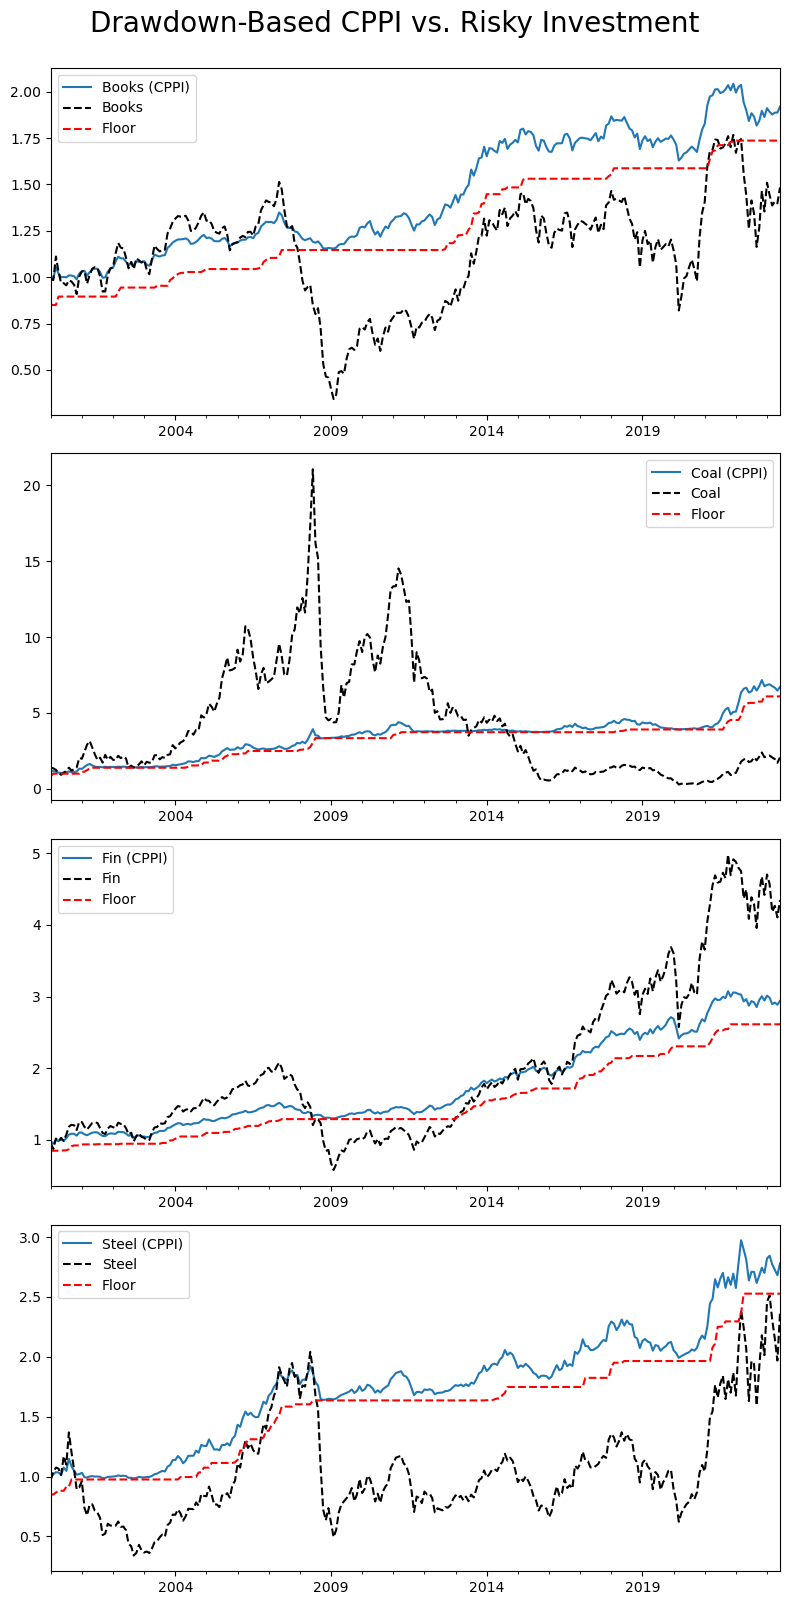

In [157]:
nrow = int(len(risky_r.columns)) 

fig, axs = plt.subplots(nrows = nrow, ncols = ncol, figsize = (8, nrow*4), sharey = False, sharex = False)
plt.subplots_adjust( wspace = 0.6)
fig.suptitle("Drawdown-Based CPPI vs. Risky Investment", fontsize = 20, y = 1)


axs = axs.ravel()

for index, ax, i in zip(risky_r.columns, axs, range(ncol*nrow)):
    wealth[index].plot(ax = ax, label = index + ' (' + 'CPPI' + ')', legend = True)
    risky_prf[index].plot(ax = ax, label = index, legend = True, color = 'black', linestyle = '--')
    target[index].plot(ax = ax, label = 'Floor', color = 'red', linestyle = '--', legend = True)

fig.tight_layout()
plt.legend()
plt.show()

In [160]:
print("                                     Performance of Risky Assets")
print("========================================================================================================")
rm.summary_stats(risky_r.iloc[:,:])

                                     Performance of Risky Assets


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Books,1.692,22.485,0.252,6.566,9.371,13.743,0.017,-77.324
Coal,3.147,47.416,0.006,3.525,21.097,28.434,0.031,-98.608
Fin,6.450,20.042,-0.487,4.691,9.384,13.275,0.064,-72.032
Steel,3.735,33.574,-0.155,3.545,15.446,20.826,0.037,-75.802


In [161]:
print("                               Performance of Drawdown-Based CPPI Strategy")
print("========================================================================================================")
rm.summary_stats(wealth.iloc[:,:].pct_change().dropna())

                               Performance of Drawdown-Based CPPI Strategy


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Books,2.833,6.135,0.028,3.452,2.629,3.456,0.028,-14.382
Coal,7.693,11.282,1.012,6.486,3.450,5.557,0.077,-15.372
Fin,4.796,6.160,-0.274,3.554,2.629,3.522,0.048,-14.378
Steel,4.514,8.386,0.475,4.231,3.181,4.281,0.045,-14.783


**Conclusion:**
* The drawdwon are significantly lower.
* All volatilities have improved.
* The *return* and *Sharpe Ratio* on `Books`, `Coal`, and `Steel` is higher.
* Note the violation of `Coal` portfolio when the return falls sharply in 2008.

### Extensions: CPPI with A Cap<a id="2.2"></a>
The second extension that I study here involves imposing a maximum to our portfolio strategy- as we discussed earlier. To implement this strategy, at each point, we should check which constraint is more likely to be binding: floor or cap. Based on that determination, the cushion and risky investment will be computed. 

In [188]:
# risky assets
assets  = ['Books', 'Coal', 'Fin', 'Steel']
risky_r = ind_return.loc["2000":,assets]

# risk-free asset: 3% per year, monthly 
riskless_r          = pd.DataFrame().reindex_like(risky_r)
riskless_r.loc[:,:] = 0.03/12


# Parameters
start = 1                        # initital assets
floor = 0.90                     # floor is 90 percent of the starting assets
m     = 3                        # multiplier
dd    = 0.15                     # drawdon limit   
cap   = 2.0                      # cap 

## DataFrame to record values
cushion_c = pd.DataFrame().reindex_like(risky_r)
wealth_c  = pd.DataFrame().reindex_like(risky_r) 
risky_w_c = pd.DataFrame().reindex_like(risky_r)
floor_c   = pd.DataFrame().reindex_like(risky_r)

In [190]:
# CPPI Algorithm with a dynamic floor and a cap

cap_val           = risky_r.iloc[0].copy()
cap_val.values[:] = cap*start

wealth_now           = risky_r.iloc[0].copy()
wealth_now.values[:] = start


floor_val = start*floor
peak_val  = wealth_now
    
    
for period in range(len(risky_r.index)):
      
    peak_val  = np.maximum(peak_val, wealth_now)                               # dynamically deteremined peak
    floor_val = (1.0 - dd) * peak_val                                          # dynamically deteremined floor
    cush_val = (wealth_now - floor_val)                                        # value of cushion based on drawdown policy 
    
    for asset in risky_r.columns:                                               # impose cap if it's closer to violate
        if (period >= 1) & (wealth_now[asset] >= (floor_val[asset] + cap_val[asset])/2):
            cush_val[asset] = (cap_val[asset] - wealth_now[asset])
            
            
#     for index in 
#     cush_val[wealth_now >= (floor_val + cap_val)/2] = (cap_val - wealth_now)   # impose cap if it's closer to violate
    
    
    share_r  = m * cush_val/wealth_now                   
    share_r  = np.minimum(share_r, 1)
    share_r  = np.maximum(share_r, 0)
    
    wealth_new = (share_r * wealth_now) * (1 + risky_r.iloc[period]) + ((1.0-share_r) * wealth_now) * (1 + riskless_r.iloc[period])
   
   
    # save variables 
    cushion_c.iloc[period] = cush_val
    risky_w_c.iloc[period] = share_r
    wealth_c.iloc[period]  = wealth_new 
    floor_c.iloc[period]   = floor_val
    
    wealth_now = wealth_new
    
# cumulative performance of risky assets
risky_prf = start*(1+risky_r).cumprod()


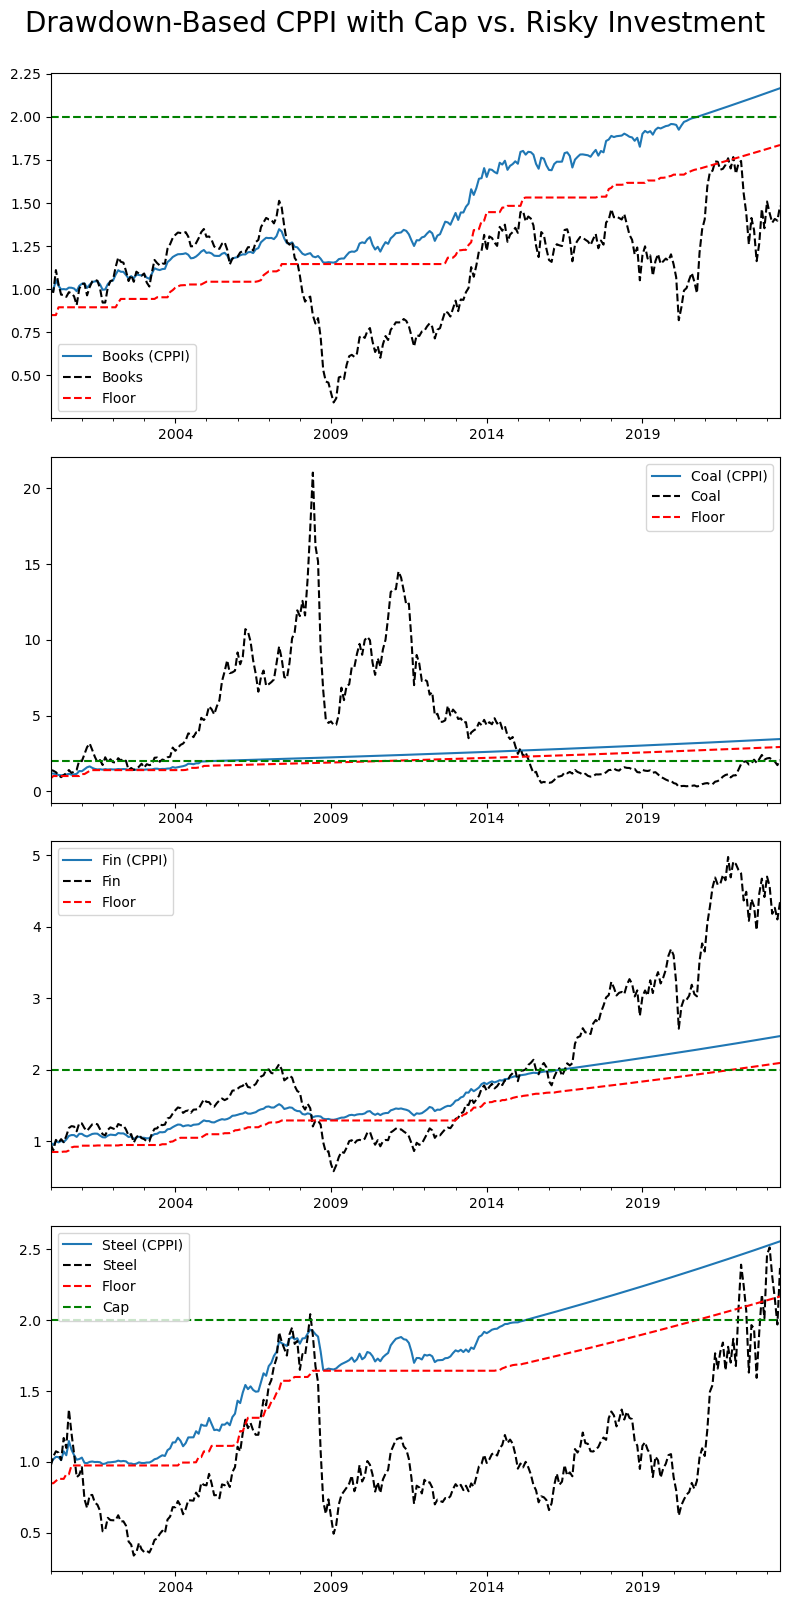

In [191]:
nrow = int(len(risky_r.columns)) 

fig, axs = plt.subplots(nrows = nrow, ncols = ncol, figsize = (8, nrow*4), sharey = False, sharex = False)
plt.subplots_adjust( wspace = 0.6)
fig.suptitle("Drawdown-Based CPPI with Cap vs. Risky Investment", fontsize = 20, y = 1)


axs = axs.ravel()

for index, ax, i in zip(risky_r.columns, axs, range(ncol*nrow)):
    wealth_c[index].plot(ax = ax, label = index + ' (' + 'CPPI' + ')', legend = True)
    risky_prf[index].plot(ax = ax, label = index, legend = True, color = 'black', linestyle = '--')
    floor_c[index].plot(ax = ax, label = 'Floor', color = 'red', linestyle = '--', legend = True)
    ax.axhline(y=cap*start, color='g', linestyle='--', label = "Cap")
    
fig.tight_layout()
plt.legend()
plt.show()

Text(0.5, 1.0, 'Weight of Risky Investment in the CPPI Portfolio with a Cap')

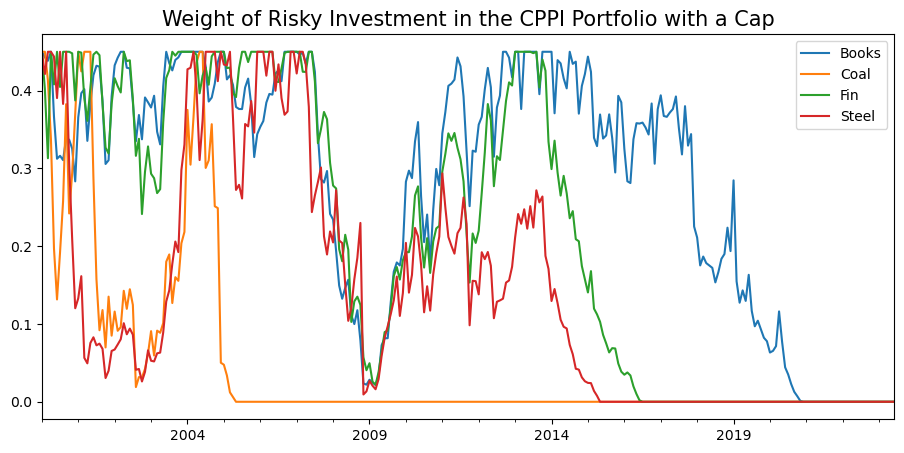

In [183]:
risky_w.plot(figsize = (11, 5), legend = True)
plt.title("Weight of Risky Investment in the CPPI Portfolio with a Cap", fontsize = 15)

In [184]:
print("                                     Performance of Risky Assets")
print("========================================================================================================")
rm.summary_stats(risky_r.iloc[:,:])

                                     Performance of Risky Assets


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Books,1.692,22.485,0.252,6.566,9.371,13.743,0.017,-77.324
Coal,3.147,47.416,0.006,3.525,21.097,28.434,0.031,-98.608
Fin,6.450,20.042,-0.487,4.691,9.384,13.275,0.064,-72.032
Steel,3.735,33.574,-0.155,3.545,15.446,20.826,0.037,-75.802


In [187]:
print("                         Performance of Drawdown-Based CPPI Strategy with a Cap")
print("========================================================================================================")
rm.summary_stats(wealth.iloc[:,:].pct_change().dropna())

                         Performance of Drawdown-Based CPPI Strategy with a Cap


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Books,3.368,5.297,0.256,4.038,2.078,2.977,0.034,-14.382
Coal,4.671,5.928,3.944,37.088,-1.174,2.908,0.047,-14.460
Fin,4.022,4.351,0.076,5.250,1.641,2.664,0.040,-14.378
Steel,4.137,5.919,0.512,9.260,1.980,3.694,0.041,-14.733


**Conclusion:**
* The drawdwon violation in `Coal` is fixed as we move out of coal very rapidly. 
* Some *Sharpe Ratio*'s have further improved. 
* For well-performing assets, risky investment is dropped to zero as we reach the cap quickly. Therefore, this is not a good long-term investmentv strategy.

Text(0.5, 1.0, 'Capped Vs. Non-Capped CPPI: Risky Weight')

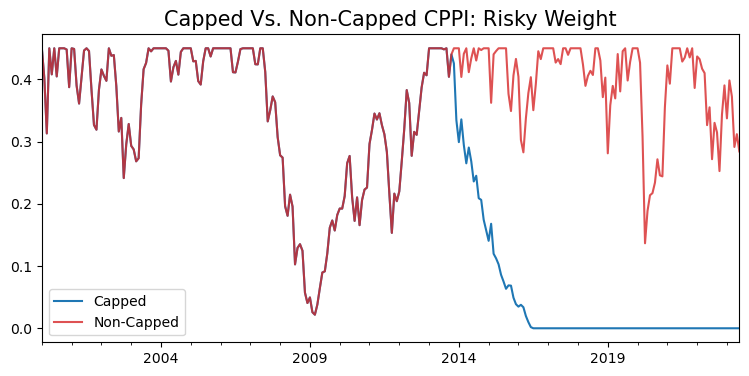

In [208]:
risky_w_c['Fin'].plot(figsize=(9, 4), label = "Capped" , legend = True)
risky_w['Fin'].plot(label = "Non-Capped" , legend = True, color = 'tab:red', alpha = 0.8)
plt.title("Capped Vs. Non-Capped CPPI: Risky Weight", fontsize = 15)

Text(0.5, 1.0, 'Capped Vs. Non-Capped CPPI: Wealth')

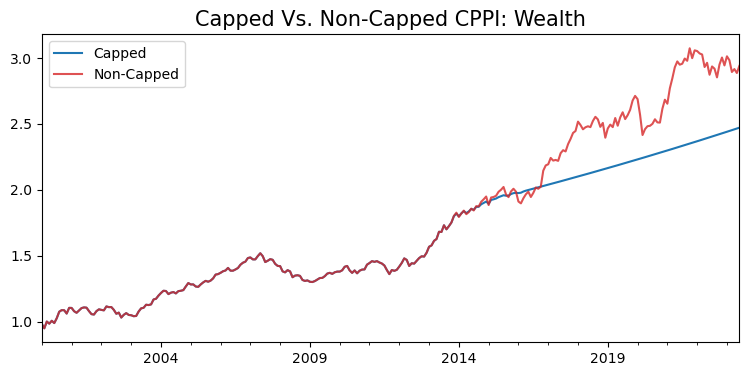

In [207]:
wealth_c['Fin'].plot(figsize=(9, 4), label = "Capped" , legend = True)
wealth['Fin'].plot(label = "Non-Capped" , legend = True, color = 'tab:red', alpha = 0.8)
plt.title("Capped Vs. Non-Capped CPPI: Wealth", fontsize = 15)

## A Monte-Carlo Simulation  <a id="3"></a>
This section explores the efficiency of the CPPI strategy in preventing floor violations. For this purpose, I first simulate multiple paths for the evolution of a risky asset -say, a stock price. Then, I build a CPPI portfolio using a risky and a riskless asset -say, government bonds, and verify whether under any circumstances the CPPI portfolio fails to protect the target floor. 

### Stock Price Simulation: Brownian Motion <a id="3.1"></a>

In order to simulate asset prices, I am going to use a `random walk` process. The basic idea is to assume that the return of a risky asset in time $X_t$ is given by
$$r_X = \frac{dX_t}{X_t} = \mu dt + \sigma dW_t$$

where $\mu$ is the determinisitc mean of the return process, and $\sigma$ denotes its volatility. 

Let's consider a riskless rate $r_f$ and the Sharpe ratio $\lambda = \frac{\mu - r_f}{\sigma}$. Then,

$$
\mu = r_f + \sigma\lambda
$$

Therefore, we can re-write the first equation as

$$ \frac{dX_t}{X_t} = (r_f + \sigma\lambda) dt + \sigma dW_t $$

This equation includes a determinisitc term (first term) and a stochastic term (second term). We can re-write the stochastic term as a `Geometric Brownian Motion`, $\xi_t$:

$$ \frac{dX_t}{X_t} = (r_f + \sigma\lambda) dt + \sigma \sqrt dt \xi_t $$

where $\xi_t \sim N(0,1)$.


This implies that the stochastic term of the equation has a mean of zero and a standard deviation of $\sigma \sqrt dt$.

In practice, we usually calibrate this model so that $\mu$ is the annualized return of the stock, and $\sigma$ is its annualized volatility. 

**Note:** An important implication of this model is that at any point in time, the probability of observing a higher return is equal to the probability of observing a lower return. 

A caveat of this model, however,is that all its parameters are constant over time, which does not seem to match the data. An alternative formulation is to assume:

$$ \frac{dX_t}{X_t} = (r_{f_t} + \sigma_t\lambda_t) dt + \sigma_t \sqrt dt \xi_t $$

To allow for time-varyin parameters, we can assume two stochastic processes for $r_{f_t}$ and $ \sigma_t$:


$$
\begin{cases}
dr_{f_t}  =  a(b-r_{f_t}) dt + \sigma_{r_f} dW_t^{r_f}\\[5mm]
d\sigma_t^2 = \alpha(\bar{\sigma}^2 - \sigma_t^2) dt + \sigma_\sigma \sqrt{\sigma_t} dW_t^{\sigma}
\end{cases}
$$

Here, we have basically assumed that 
1. Riskless rate follows a `mean-reverting` process with
    * $a$: speed of mean-reversion 
    * $b$: long-term constant mean

2. Riskless asset is subject to a tim-dependent shock that follows a `Brownian` motion.
    * The volatility of this Brownian Motion is constant over time.


3. The volatility of the risky asset follows a `mean-reverting` process with
    * $\alpha$: speed of mean-reversion 
    * $\bar{\sigma}$: long-term constant volatility of the asset
    
4. The volatility of the risky asset is subject to a random shock.
    * The volatility of this Brownian motion is constant over time.
    
**Note:** Since the volatility can't a be negative number, we need to make sure that as $\sigma_t^2$ gets closer to zero, its change over time, $d\sigma_t^2$, does not push its value to negative territories. For this reason, the shock to volatility is scaled with $ \sqrt{\sigma_t}$ so that as the level goes down to zero, the impact of the random component is basically eliminated. Then, mean-reversion, the only remaining factor, will determine the volatility, which will always be positive.


In this simulation, I am going to assume a process with a constant mean and a constant volatility.

$$ \frac{X_{t+dt}-X_t}{X_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

In [90]:
def price_sim(sim_length, freq, n_paths, mu, sigma, x_0):
    """
    Inputs
        sim_length : length of simulation period in years
        freq       : frequency of data in a year; e.g., "12" for monthly
        n_paths    : number of paths to be simulated
        mu         : annaulized mean
        sigma      : annualized volatility
        x_0        : initial stock price
    
    Output
        simulated prices as a dataframe
    """
        
    n     = int(sim_length*freq)                 # number of simulations on each path
    dt    = 1.0/freq                             # time interval between two consequtive simulations on each path
    xi    = np.random.normal(size=(n, n_paths))  # stochastic components of price as a normal random variable
    rx    = mu*dt + sigma*np.sqrt(dt)*xi         # return paths

    rx    = pd.DataFrame(rx)                     # return paths as a dataframe
    sim_p = x_0 * (1 + rx).cumprod()             # simulated price paths as a dataframe
    
    return sim_p

In [84]:
sim_length = 12
freq       = 12
n_paths    = 1000
mu         = 0.06
sigma      = 0.15
x_0        = 1.0

price_paths = price_sim(sim_length, freq, n_paths, mu, sigma, x_0)

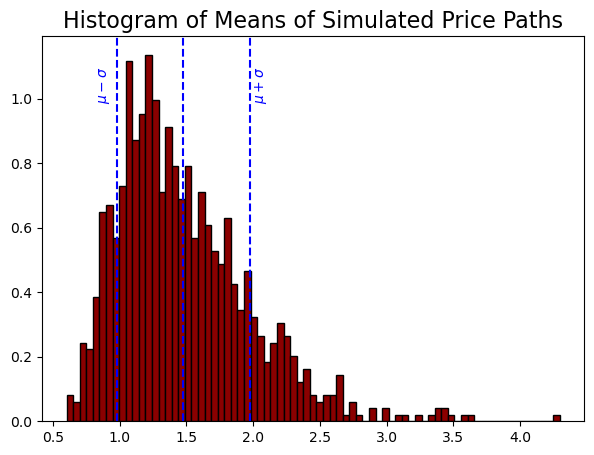

In [89]:
fig, ax = plt.subplots(figsize = (7, 5))
plt.hist(price_paths.mean(), bins = 75, facecolor = "darkred", edgecolor = 'black', density = True)
plt.axvline(price_paths.mean().mean(), linestyle = 'dashed', color = 'blue')
plt.axvline(price_paths.mean().mean() + price_paths.mean().std(), linestyle = 'dashed', color = 'blue')
plt.axvline(price_paths.mean().mean() - price_paths.mean().std(), linestyle = 'dashed', color = 'blue')
ax.annotate('$\mu + \sigma$', xy=(2, 1), xytext=(2.00, 1.00), color = 'blue', rotation = 90)
ax.annotate('$\mu - \sigma$', xy=(2, 1), xytext=(0.83, 1.00), color = 'blue', rotation = 90)
plt.title("Histogram of Means of Simulated Price Paths", fontsize = 16)
plt.show()

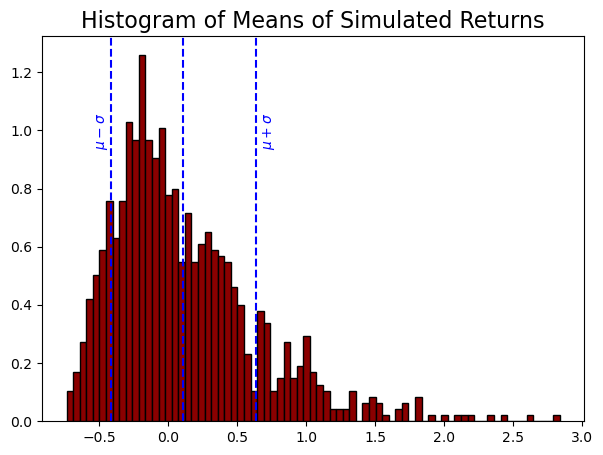

In [87]:
fig, ax = plt.subplots(figsize = (7, 5))
plt.hist(price_paths.mean().pct_change(), bins = 75, facecolor = "darkred", edgecolor = 'black', density = True)
plt.axvline(price_paths.mean().pct_change().mean(), linestyle = 'dashed', color = 'blue')
plt.axvline(price_paths.mean().pct_change().mean() + price_paths.mean().pct_change().std(), linestyle = 'dashed', color = 'blue')
plt.axvline(price_paths.mean().pct_change().mean() - price_paths.mean().pct_change().std(), linestyle = 'dashed', color = 'blue')
ax.annotate('$\mu + \sigma$', xy=(2, 1), xytext=(0.67, 0.95), color = 'blue', rotation = 90)
ax.annotate('$\mu - \sigma$', xy=(2, 1), xytext=(-0.53, 0.95), color = 'blue', rotation = 90)
plt.title("Histogram of Means of Simulated Returns", fontsize = 16)
plt.show()

This simulation provides us with the basics of what we need to simulate the performance of a CPPI portfolio. In the following, I consider above paths for future returns of our risky investment. I use a function that plots the characteristics of a CPPI portfolio in an interactive panel.

### CPPI Simulation <a id="3.2"></a>

In [77]:
def cppi_dd(risky_r, riskless_r, w_0, m, floor, dd):
    
    """
    Implements Drawdown-Based CPPI 
    
    Inputs
        risky_r     :  dataframe of risky returns
        riskless_r  :  dataframe of riskless returns
        w_0         :  initial wealth
        m           :  CPPI multiplier
        floor       :  protected floor as a percentage of initial wealth
        dd          :  drawdown limit
        
    Output
        A dictionary of dataframes that includes: 
            cushion, wealth, risky weight, protected wealth,
            and performance of risky asset 
    """

    # DataFrame to record values
    cushion = pd.DataFrame().reindex_like(risky_r)
    wealth  = pd.DataFrame().reindex_like(risky_r) 
    risky_w = pd.DataFrame().reindex_like(risky_r)
    target  = pd.DataFrame().reindex_like(risky_r)

    # CPPI Algorithm with a dynamic floor
    floor_val  = w_0*floor
    peak_val   = w_0*floor
    wealth_now = w_0

    for period in range(len(risky_r.index)):

        peak_val  = np.maximum(peak_val, wealth_now)         # dynamically deteremined peak
        floor_val = (1.0 - dd) * peak_val                    # dynamically deteremined floor

        cush_val = (wealth_now - floor_val)                  # value of cushion  
        share_r  = m * cush_val/wealth_now                   # share of risky investment
        share_r  = np.minimum(share_r, 1)
        share_r  = np.maximum(share_r, 0)

        wealth_new = (share_r * wealth_now) * (1 + risky_r.iloc[period]) + ((1.0-share_r) * wealth_now) * (1 + riskless_r.iloc[period])


        # save variables 
        cushion.iloc[period] = cush_val
        risky_w.iloc[period] = share_r
        wealth.iloc[period]  = wealth_new 
        target.iloc[period]  = floor_val

        wealth_now = wealth_new

    # cumulative performance of risky assets
    risky_prf = start*(1+risky_r).cumprod()

    result = {"wealth"    : wealth,
              "risky_w"   : risky_w, 
              "cushion"   : cushion,
              "target "   : target,
              "risky_prf" : risky_prf}
    
    return result

In [128]:
def cppi_paths(sim_length, freq, n_paths, mu, sigma, x_0, rf, w_0, m, floor, dd):
      
    """
    Combines the path simulation of rsiky asset with the implementation of a drawdown-based CPPI 
    
    Inputs
        sim_length  :  length of simulation period in years
        freq        :  frequency of data in a year; e.g., "12" for monthly
        n_paths     :  number of paths to be simulated
        mu          :  annaulized mean
        sigma       :  annualized volatility
        x_0         :  initial price of risky asset
        rf          :  annual return of riskless asset
        w_0         :  initial wealth
        m           :  CPPI multiplier
        floor       :  protected floor as a percentage of initial wealth
        dd          :  drawdown limit
        
    Output
        A plot for all simulated CPPI wealth paths under each simulation scenario
    """
#   Risky asset: Simulation
    price_paths       = price_sim(sim_length, freq, n_paths, mu, sigma, x_0)
    risky_r           = price_paths.pct_change()
    risky_r.iloc[0,:] = 0.0
    
#   Riskless asset: 3% per year, monthly 
    riskless_r          = pd.DataFrame().reindex_like(risky_r)
    riskless_r.loc[:,:] = rf/12
    
    # run the CPPI
    cppi = cppi_dd(risky_r, riskless_r, w_0, m, floor, dd)
    cppi_w = cppi["wealth"]    
    
    ax = cppi_w.plot(legend = False, alpha = 0.4, color = "darkred", figsize = (11, 5))
    ax.axhline(y = w_0, linestyle = ":", color = "black")
    ax.axhline(y = w_0 * floor, linestyle = "--", color = "red")
    plt.title("Simulated CPPI Wealth", fontsize = 16)
  
        

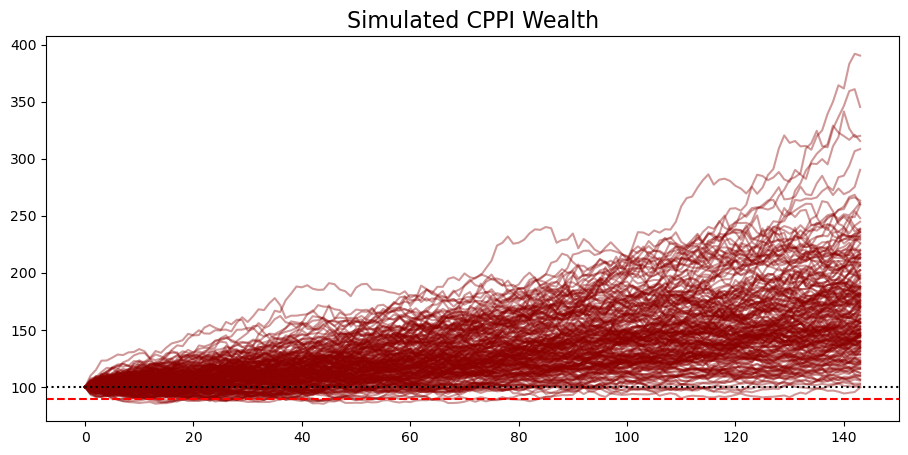

In [129]:
sim_length = 12
freq       = 12
n_paths    = 200
mu         = 0.06
sigma      = 0.15
x_0        = 1.0
rf         = 0.03
w_0        = 100
m          = 3
floor      = 0.90
dd         = 0.20


cppi_paths(sim_length, freq, n_paths, mu, sigma, x_0, rf, w_0, m, floor, dd)

In [155]:
# interactive simulation
cppi_int = ipywidgets.interact(cppi_paths,
                               sim_length  = (5.00, 12.00, 1),
                               freq        =  ipywidgets.fixed(12), 
                               n_paths     = (0, 1000,  5), 
                               mu          = (0.00, 0.20, 0.01),
                               sigma       = (0.00, 0.40, 0.01),
                               x_0         = ipywidgets.fixed(1.0),
                               rf          = (0, .05, .01),
                               w_0         = ipywidgets.fixed(100),
                               floor       = (0.00, 1.00, 0.05),
                               m           = (1.00, 5.00, 0.50),
                               dd          = (0.60, 1.00, 0.05)
                                )

interactive(children=(FloatSlider(value=8.0, description='sim_length', max=12.0, min=5.0, step=1.0), IntSlider…

**Conclusion:**
The CPPI is a robust insurance strategy as the floor rarely gets violated. However, violations are more likely
    * the number of simulated paths rises
    * as the risky asset gets riskier (higher $\sigma$)
    * risky assets has a lower return, on average (lower $\mu$)
    * floor is more restrictive (larger drawdowns are tolerated)
 
I close this simulation exercise by statistically analyzing floor violations.

In [193]:
def floor_violations(sim_length, freq, n_paths, mu, sigma, x_0, rf, w_0, m, floor, dd):
      
    """
    Combines the path simulation of rsiky asset with the implementation of a drawdown-based CPPI 
    
    Inputs
        sim_length  :  length of simulation period in years
        freq        :  frequency of data in a year; e.g., "12" for monthly
        n_paths     :  number of paths to be simulated
        mu          :  annaulized mean
        sigma       :  annualized volatility
        x_0         :  initial price of risky asset
        rf          :  annual return of riskless asset
        w_0         :  initial wealth
        m           :  CPPI multiplier
        floor       :  protected floor as a percentage of initial wealth
        dd          :  drawdown limit
        
    Output
        Histograms of simulated CPPI wealth paths
    """
    
#   Risky asset: Simulation
    price_paths       = price_sim(sim_length, freq, n_paths, mu, sigma, x_0)
    risky_r           = price_paths.pct_change()
    risky_r.iloc[0,:] = 0.0
    
#   Riskless asset: 3% per year, monthly 
    riskless_r          = pd.DataFrame().reindex_like(risky_r)
    riskless_r.loc[:,:] = rf/12
    
    # run the CPPI
    cppi = cppi_dd(risky_r, riskless_r, w_0, m, floor, dd)
    cppi_w = cppi["wealth"]    
    
    # calculate wealth at the end of simulation and compute some stats
    fw         = cppi_w.iloc[-1]                      # Final Wealth    
    fw_mean    = fw.mean()
    fw_median  = fw.median()
    flag_v     = np.less(fw, w_0*floor)              # flag for floor violations
    n_violate  = flag_v.sum()                        # number of floor violations
    p_violate  = n_violate/n_paths                   # prob. of floor violations

    if n_violate > 0:
        avg_v = np.dot(fw - w_0*floor, flag_v)/n_violate
    else:
        avg_v = 0.0
    
         
    # Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows = 1, ncols = 2, sharey = True,
                                             gridspec_kw = {'width_ratios':[3,2]}, figsize = (24, 9))
    plt.subplots_adjust(wspace = 0.02)
    
    cppi_w.plot(ax = wealth_ax, legend = False, alpha = 0.3, color = "darkred")
    wealth_ax.axhline(y = w_0, ls = ":", color = "black")
    wealth_ax.axhline(y = w_0*floor, ls = "--", color = "red")
    
    fw.plot.hist(ax = hist_ax, bins = 75, edgecolor = 'black', facecolor = 'darkred', legend = False,
                                                             alpha = 0.75, orientation = 'horizontal')
    hist_ax.axhline(y = w_0, linestyle = ":", color = "black")
    hist_ax.axhline(y = fw_mean, linestyle = ":", color = "blue")
    hist_ax.axhline(y = fw_median, linestyle = ":", color = "purple")
    hist_ax.annotate(f"Mean: ${int(fw_mean)}", xy = (.5, .9), xycoords = 'axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(fw_median)}", xy = (.5, .85), xycoords = 'axes fraction', fontsize=24)
    if (floor > 0.10):
        hist_ax.axhline(y=w_0*floor, linestyle = "--", color = "red", linewidth = 3)
        hist_ax.annotate(f"Violations: {n_violate} ({p_violate*100:2.2f}%)\nAvg. loss: ${avg_v:2.2f}",
                                                              xy = (.5, .7), xycoords = 'axes fraction', fontsize = 24)
    
    plt.suptitle("Floor Violations Under Simulated Paths", fontsize = 30)
        
    


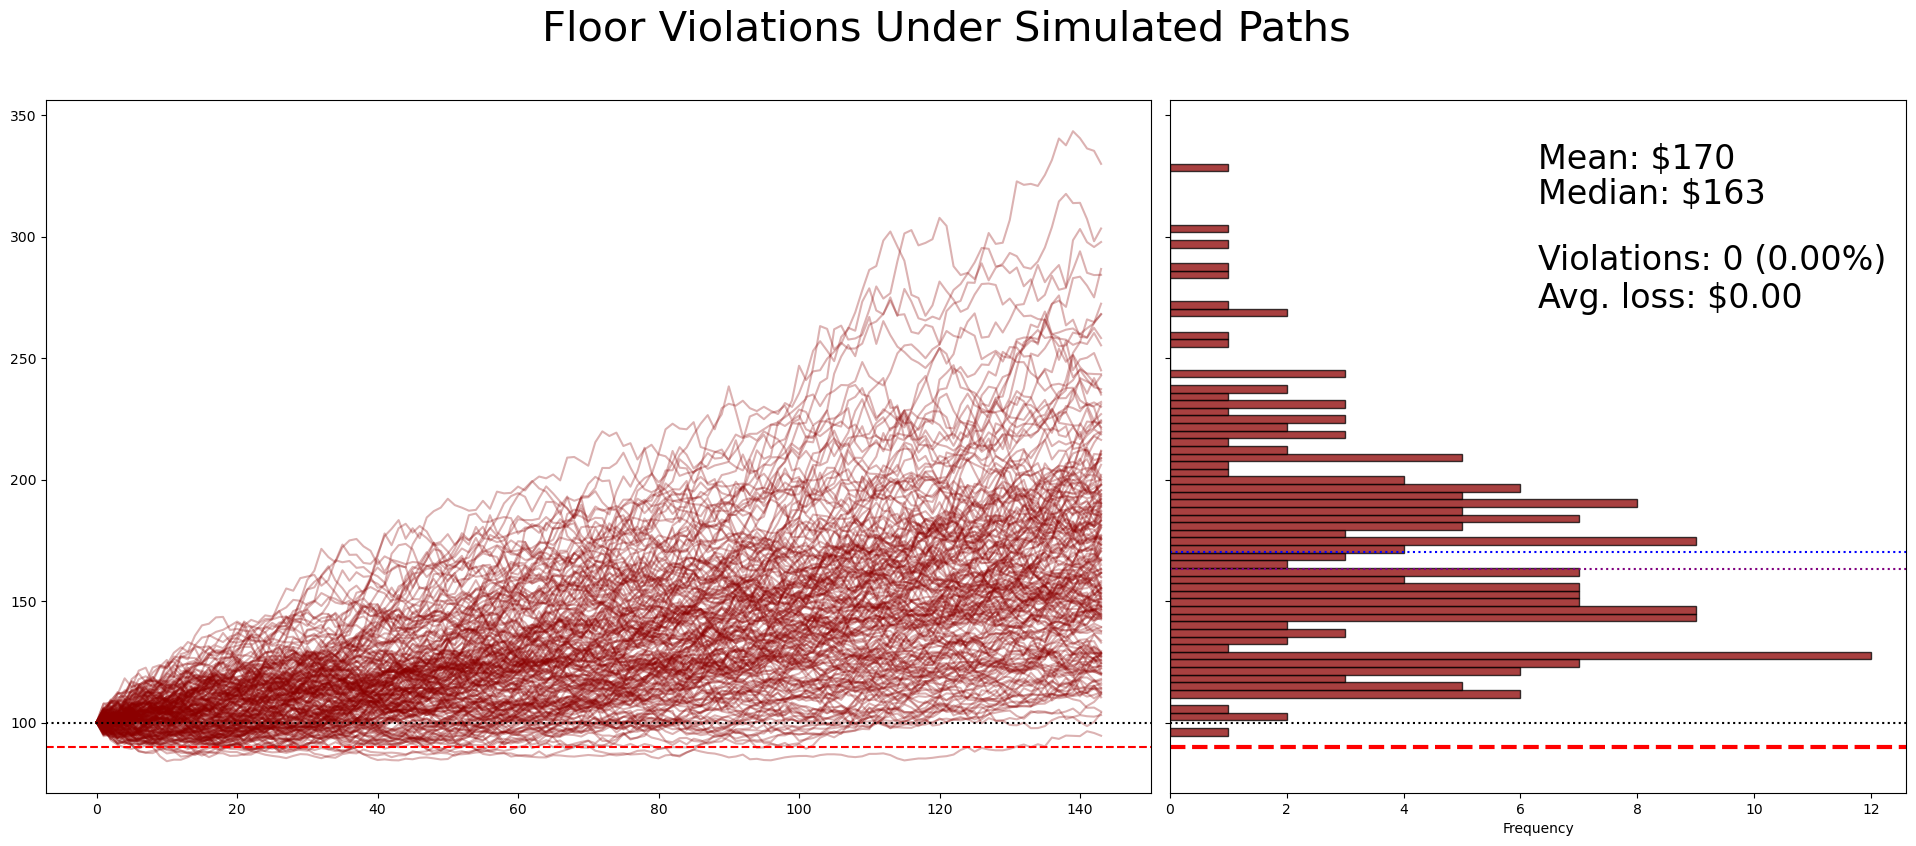

In [194]:
floor_violations(sim_length, freq, n_paths, mu, sigma, x_0, rf, w_0, m, floor, dd)

In [198]:
# Interactive Analysis of floor violations

violate_int = ipywidgets.interact(floor_violations,
                               sim_length  = (5.00, 12.00, 1),
                               freq        =  ipywidgets.fixed(12), 
                               n_paths     = (0, 500,  50), 
                               mu          = (0.00, 0.20, 0.01),
                               sigma       = (0.00, 0.40, 0.01),
                               x_0         = ipywidgets.fixed(1.0),
                               rf          = (0, .05, .01),
                               w_0         = ipywidgets.fixed(100),
                               floor       = (0.00, 1.00, 0.05),
                               m           = (1.00, 5.00, 0.50),
                               dd          = (0.00, 1.00, 0.05)
                                )



interactive(children=(FloatSlider(value=8.0, description='sim_length', max=12.0, min=5.0, step=1.0), IntSlider…

**Conclusion:**

This interatcitve panel allows us to better understand how the CPPI strategy works and how it responds to changes in parameters:
* Higher $m \rightarrow$ more floor vilations and higher shortfalls
* higher $\sigma \rightarrow$  more floor vilations and higher shortfalls

